# Comparison of various PPCA models
In this notebook, we compare my PPCA solution (both the closed-form solution and the EM algorithm) with various solutions found online.

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

os.sys.path.append('Other_examples/')
import PPCA_angermueller as ppca_angermueller
import ppca_ymcdull
import pystan

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
import functools
import warnings
tf.enable_v2_behavior()
# import ppca as ppca_tran
import pyppca

### General dataset to be tested

In [38]:
N=5000
M=2
D=3

In [39]:
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
print('mu: ', mu)
print('sigma2: ', sigma**2)
print('W: ', W)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
sigma2:  3.045581684330065
W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]


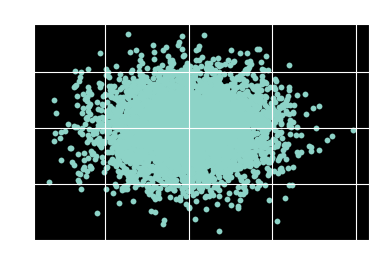

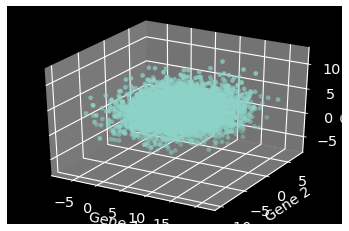

In [40]:
plt.figure()
plt.scatter(z[0,:], z[1,:])
plt.title('latent data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:])
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

# Closed-form solutions

## My solution
This approach was built by me and lives in this repository.

In [41]:
mu_ML = np.mean(x,axis=1)[np.newaxis].T
S = np.cov(x)
eigenvalues, eigenvectors = np.linalg.eig(S)
order = np.argsort(eigenvalues)[::-1]
eigenvalues = np.sort(eigenvalues)[::-1]
eigenvectors = eigenvectors[order]
sigma_ML = 0.0
for i in range(M,D):
    sigma_ML += eigenvalues[i]
sigma_ML = sigma_ML/(D-M)
U = eigenvectors[:M].T
L = np.diag(eigenvalues[:M])
R = np.eye(M)
W_ML = np.matmul(np.matmul(U,np.sqrt((L-sigma_ML*np.eye(M)))),R)
x_sim_closed = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

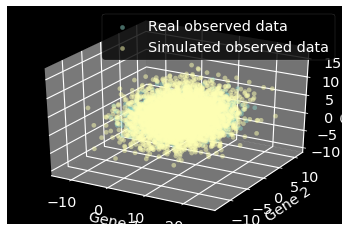

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.5, label='Real observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.5, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [43]:
mu_ML_closed_me = mu_ML.copy()
sigma_ML_closed_me = sigma_ML.copy()
W_ML_closed_me = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_closed_me)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', sigma_ML_closed_me)
print()
print('W: ', W)
print('W_ML: ', W_ML_closed_me)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]

sigma2:  3.045581684330065
sigma_ML:  3.1322872491704947

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  [[ 3.63301294  0.2263789 ]
 [ 1.21333491 -1.09019103]
 [ 0.23821563  2.1003213 ]]


## Angermuellers PPCA
This solution is taken from https://github.com/cangermueller/ppca to compare with my approach. The original code has been altered slightly for compatibility purposes.

In [44]:
ppca = ppca_angermueller.PPCA()
ppca.fit(x)
z_angermueller = ppca.transform()
x_angermueller = np.random.normal(np.matmul(ppca.w,z)+ppca.mu,ppca.sigma)

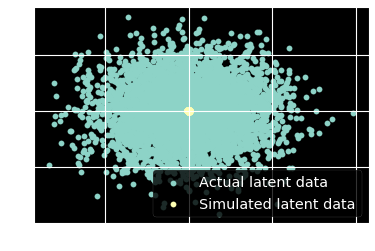

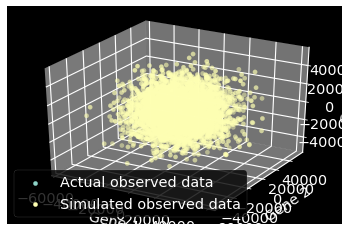

In [45]:
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller[0,:],z_angermueller[1,:], label='Simulated latent data')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data')
ax.scatter(x_angermueller[0,:],x_angermueller[1,:],x_angermueller[2,:], label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [46]:
mu_ML_angermueller = ppca.mu.copy()
sigma_ML_angermueller = ppca.sigma.copy()
W_ML_angermueller = ppca.w.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_angermueller)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', sigma_ML_angermueller)
print()
print('W: ', W)
print('W_ML: ', W_ML_angermueller)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]

sigma2:  3.045581684330065
sigma_ML:  15658.303958603303

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  [[-282.86496484   13.00680395]
 [ -91.97224716  -97.27982689]
 [ -28.4543572   185.13421704]]


# EM solutions

## My solution
This approach was built by me and lives in this repository.

In [47]:
for iteration in range(50):
    S = np.cov(x)
    M_mat = sigma_ML*np.eye(M) + np.matmul(W_ML.T,W_ML)
    W_ML_new = np.matmul(np.matmul(S,W_ML),np.linalg.inv(sigma_ML*np.eye(M)+np.matmul(np.matmul(np.matmul(np.linalg.inv(M_mat),W_ML.T),S),W_ML)))
    sigma_ML = np.trace(S-np.matmul(np.matmul(np.matmul(S,W_ML),np.linalg.inv(M_mat)),W_ML_new.T))/D
    W_ML = W_ML_new.copy()
x_sim_em = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

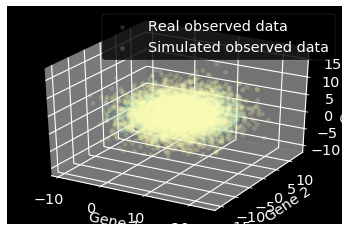

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2, label='Real observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [49]:
mu_ML_em_me = mu_ML.copy()
sigma_ML_em_me = sigma_ML.copy()
W_ML_em_me = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_em_me)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', sigma_ML_em_me)
print()
print('W: ', W)
print('W_ML: ', W_ML_em_me)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]

sigma2:  3.045581684330065
sigma_ML:  3.132287249627669

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  [[ 3.62703255  0.25532728]
 [ 1.21349394 -1.06807846]
 [ 0.3029563   2.11024312]]


## Angermuellers algorithm
This algorithm is taken from https://github.com/cangermueller/ppca to compare with my approach. The original code has been altered slightly for compatibility purposes.

In [50]:
ppca = ppca_angermueller.PPCA()
ppca.fit(x, em=True)
z_angermueller_em = ppca.transform()
x_angermueller_em = np.random.normal(np.matmul(ppca.w,z)+ppca.mu,ppca.sigma)

  1  -5.561
  2  -5.302
  3  -5.198
  4  -5.104
  5  -5.002
  6  -4.888
  7  -4.773
  8  -4.665
  9  -4.571
 10  -4.493
 11  -4.429
 12  -4.379
 13  -4.339
 14  -4.309
 15  -4.286
 16  -4.268
 17  -4.255
 18  -4.244
 19  -4.237
 20  -4.231


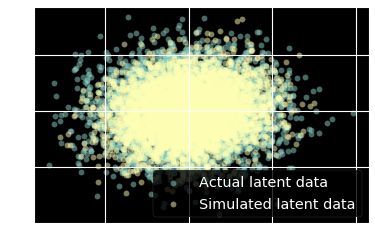

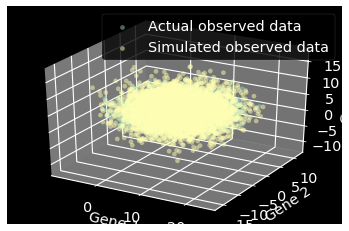

In [51]:
plt.scatter(z[0,:], z[1,:], label='Actual latent data', alpha=0.5)
plt.scatter(z_angermueller_em[0,:],z_angermueller_em[1,:], label='Simulated latent data', alpha=0.5)
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data', alpha=0.5)
ax.scatter(x_angermueller_em[0,:],x_angermueller_em[1,:],x_angermueller_em[2,:], label='Simulated observed data', alpha=0.5)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [52]:
mu_ML_angermueller_em = ppca.mu.copy()
sigma_ML_angermueller_em = ppca.sigma.copy()
W_ML_angermueller_em = ppca.w.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_angermueller_em)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', sigma_ML_angermueller_em)
print()
print('W: ', W)
print('W_ML: ', W_ML_angermueller_em)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]

sigma2:  3.045581684330065
sigma_ML:  3.1704934583900632

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  [[ 2.81925217  2.26423593]
 [ 1.59563492 -0.18310761]
 [-0.94596694  1.892582  ]]


## Ymcdulls algorithm

In [53]:
ppca = ppca_ymcdull.PPCA(D = 2, n_iters = 100, verbose = True)
ppca.fit(x.T)

Lower bound: -46498.765623580104
0
Lower bound: -43170.15066465415
1
Lower bound: -42179.188128258495
2
Lower bound: -41816.67732302587
3
Lower bound: -41629.33200710769
4
Lower bound: -41513.88890720649
5
Lower bound: -41437.54265624041
6
Lower bound: -41385.38692337033
7
Lower bound: -41348.99455449228
8
Lower bound: -41323.129865539915
9
Lower bound: -41304.42045892644
10
Lower bound: -41290.65745878312
11
Lower bound: -41280.37532477023
12
Lower bound: -41272.587793284256
13
Lower bound: -41266.62003550363
14
Lower bound: -41262.00174206997
15
Lower bound: -41258.39883274584
16
Lower bound: -41255.56954911265
17
Lower bound: -41253.33590903498
18
Lower bound: -41251.564865987355
19
Lower bound: -41250.15564671616
20
Lower bound: -41249.03107206088
21
Lower bound: -41248.13148613323
22
Lower bound: -41247.41042688003
23
Lower bound: -41246.83148198748
24
Lower bound: -41246.36596851221
25
Lower bound: -41245.99119628165
26
Lower bound: -41245.689152442574
27
Lower bound: -41245.4454

[[-1.484789   -7.7997459 ]
 [-1.57808553  0.65804559]
 [ 1.5550681  -2.73496133]]
0.26587188558968466
[[-0.90182726 -1.04962019]
 [-0.2126496  -0.16296868]
 [ 0.99245925 -1.13101627]
 ...
 [ 0.56424983 -0.36053999]
 [-1.16521912 -1.28252073]
 [-0.09620214 -1.29755455]]


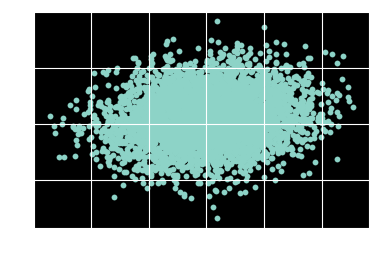

In [54]:
ymcdull_w = ppca.e_w
ymcdull_tau = ppca.e_tau
ymcdull_x = ppca.e_X

print(ymcdull_w)
print(ymcdull_tau)
print(ymcdull_x)
plt.scatter(ymcdull_x[:, 0], ymcdull_x[:, 1])
plt.show()

# PyStan

In [55]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    matrix[N,D] x;//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D){
        W[d] ~ normal(0.0,sigma);
        mu[d]~normal(0.0, 5.0) ;
        }
    sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
}
"""
ppca = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97b5609a35425dcdc7914eae6f54f7bd NOW.


In [56]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}
op = ppca.optimizing(data=ppca_dat)

z_sim_pystan = op['z'].T
sigma_sim_pystan = op['sigma']
W_sim_pystan = op['W'].T
mu_sim_pystan = op['mu'].T
x_sim_pystan = np.random.normal(np.matmul(z_sim_pystan,W_sim_pystan)+mu_sim_pystan,sigma_sim_pystan)

print('real mu: ', mu)
print('simulated mu: ', mu_sim_pystan)
print()
print('sigma2: ', sigma**2)
print('simulated sigma: ', sigma_sim_pystan**2)
print()
print('real z: ', z)
print('simulated z: ', z_sim_pystan)
print()
print('real W: ', W)
print('simulated W: ', W_sim_pystan)
print()

real mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
simulated mu:  [ 7.16269304 -0.97401592  2.46324917]

sigma2:  3.045581684330065
simulated sigma:  1.0785787096589945

real z:  [[-0.81168483 -0.9054334   1.60838506 ... -0.02873302  0.04962156
   0.2308759 ]
 [-0.72027778  0.6971369  -0.46562472 ...  1.04560137 -0.68619479
  -1.9141033 ]]
simulated z:  [[-0.13881721  0.21958552]
 [ 0.37376549  0.11836837]
 [-0.13044071 -0.29382209]
 ...
 [ 0.31670499 -0.08614891]
 [-0.22846314  0.30100704]
 [-0.23435316 -0.00513272]]

real W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
simulated W:  [[-15.76811662  -2.44243207  -6.44749416]
 [  5.42061828   8.35639909 -11.39527474]]



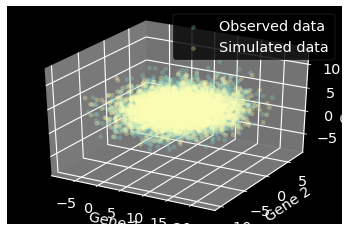

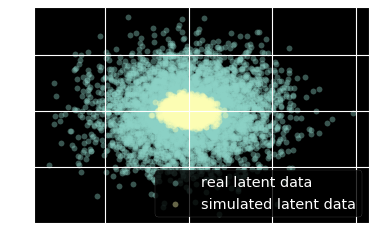

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Observed data', alpha=0.3)
ax.scatter(x_sim_pystan[:,0],x_sim_pystan[:,1],x_sim_pystan[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim_pystan[:,0], z_sim_pystan[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

In [58]:
print('mu: ', mu)
print('mu_ML: ', mu_sim_pystan)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', sigma_sim_pystan**2)
print()
print('W: ', W)
print('W_ML: ', W_sim_pystan)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [ 7.16269304 -0.97401592  2.46324917]

sigma2:  3.045581684330065
sigma_ML:  1.0785787096589945

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  [[-15.76811662  -2.44243207  -6.44749416]
 [  5.42061828   8.35639909 -11.39527474]]


# TensorFlow

In [59]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=3.0*tf.ones([data_dim,1]),
                 scale=5.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    
x_train = tf.convert_to_tensor(x,dtype=tf.float32)
concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=D,
    latent_dim=M,
    num_datapoints=N,
    stddv_datapoints=sigma)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

w_tf = tf.Variable(np.ones([D, M]), dtype=tf.float32)
z_tf = tf.Variable(np.ones([M, N]), dtype=tf.float32)
mu_tf = tf.expand_dims(tf.reduce_mean(x_train, 1),1)

target_log_prob_fn_mu = lambda w_tf, z_tf, mu_tf: model_mu.log_prob((w_tf, z_tf, mu_tf, x_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_tf, z_tf, mu_tf),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

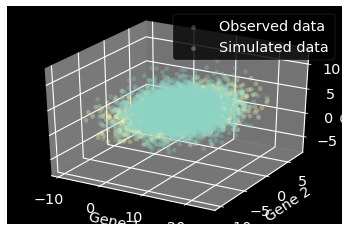

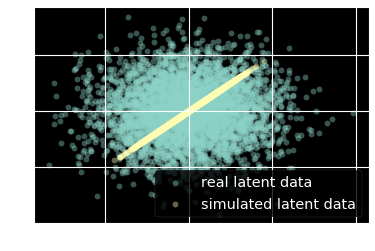

In [60]:
_, _, _, x_generated_mu = model_mu.sample(value=(w_tf, z_tf, mu_tf, None))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], label='Observed data', alpha=0.3)
ax.scatter(x_generated_mu[0,:],x_generated_mu[1,:],x_generated_mu[2,:], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_tf[0,:], z_tf[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

In [61]:
print('mu: ', mu)
print('mu_ML: ', mu_tf)
print()
print('W: ', W)
print('W_ML: ', w_tf)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  tf.Tensor(
[[ 7.175618  ]
 [-0.97248214]
 [ 2.4693801 ]], shape=(3, 1), dtype=float32)

W:  [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
W_ML:  <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[3.9773788 , 3.9773788 ],
       [1.3063577 , 1.3063577 ],
       [0.40367085, 0.40367085]], dtype=float32)>


## PPCA library by Allen Tran
 As published on https://pypi.org/project/ppca/

In [62]:
# ppca_tran = ppca_tran.PPCA()
# ppca_tran.fit(x, tol=1e-2, verbose=False)
# ppca_tran.transform()

Unfortunately, mostly due to the scarcity of its documentation, no solutions were derived by use of this package.

## Pyppca library by Sheridan Green
As published on https://pypi.org/project/pyppca/

In [63]:
C_pyppca, ss_pyppca, M_pyppca, X_pyppca, Ye_pyppca = pyppca.ppca(x.T, d=M, dia=False)

In [64]:
print('mu: ', mu)
print('mu_ML: ', M_pyppca)
print()
print('sigma2: ', sigma**2)
print('sigma_ML: ', ss_pyppca)

mu:  [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
mu_ML:  [ 7.17561902 -0.97248221  2.46937992]

sigma2:  3.045581684330065
sigma_ML:  3.2508624403223583


# Overall Comparison

## Closed solutions

In [65]:
print('real mu:\n', mu)
print('my solution:\n', mu_ML_closed_me)
print('Angermuellers solution:\n',mu_ML_angermueller)
print()
print()
print('real sigma2: ', sigma**2)
print('my solution: ', sigma_ML_closed_me)
print('Angermuellers solution: ',sigma_ML_angermueller)
print()
print('real W:\n', W)
print('my solution:\n', W_ML_closed_me)
print('Angermuellers solution:\n',W_ML_angermueller)

real mu:
 [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
my solution:
 [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]
Angermuellers solution:
 [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]


real sigma2:  3.045581684330065
my solution:  3.1322872491704947
Angermuellers solution:  15658.303958603303

real W:
 [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
my solution:
 [[ 3.63301294  0.2263789 ]
 [ 1.21333491 -1.09019103]
 [ 0.23821563  2.1003213 ]]
Angermuellers solution:
 [[-282.86496484   13.00680395]
 [ -91.97224716  -97.27982689]
 [ -28.4543572   185.13421704]]


## Iterative solutions

In [66]:
print('real mu:\n', mu)
print('my solution:\n', mu_ML_em_me)
print('Angermuellers solution:\n',mu_ML_angermueller_em)
print('Ymcdulls solution:\nnot included')
print('PyStans solution:\n', mu_sim_pystan)
print('TensorFlows solution:\n', mu_tf.numpy())
print('PyPPCAs solution:\n', M_pyppca)
print()
print()
print('real sigma2: ', sigma**2)
print('my solution: ', sigma_ML_em_me)
print('Angermuellers solution: ',sigma_ML_angermueller_em)
print('Ymcdulls solution: ', ymcdull_tau)
print('PyStans solution: ', sigma_sim_pystan**2)
print('TensorFlows solution: not included')
print('PyPPCAs solution:\n', ss_pyppca)
print()
print('real W:\n', W)
print('my solution:\n', W_ML_em_me)
print('Angermuellers solution:\n',W_ML_angermueller_em)
print('Ymcdulls solution:\n', ymcdull_w)
print('PyStans solution:\n', W_sim_pystan)
print('TensorFlows solution:\n', w_tf.numpy())
print('PyPPCAs solution: not included' )

real mu:
 [[ 7.20730856]
 [-0.97396435]
 [ 2.48150637]]
my solution:
 [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]
Angermuellers solution:
 [[ 7.17561902]
 [-0.97248221]
 [ 2.46937992]]
Ymcdulls solution:
not included
PyStans solution:
 [ 7.16269304 -0.97401592  2.46324917]
TensorFlows solution:
 [[ 7.175618  ]
 [-0.97248214]
 [ 2.4693801 ]]
PyPPCAs solution:
 [ 7.17561902 -0.97248221  2.46937992]


real sigma2:  3.045581684330065
my solution:  3.132287249627669
Angermuellers solution:  3.1704934583900632
Ymcdulls solution:  0.26587188558968466
PyStans solution:  1.0785787096589945
TensorFlows solution: not included
PyPPCAs solution:
 3.2508624403223583

real W:
 [[ 0.07055808 -3.70047468]
 [-1.08932072 -1.17659701]
 [ 2.08458439 -0.45393579]]
my solution:
 [[ 3.62703255  0.25532728]
 [ 1.21349394 -1.06807846]
 [ 0.3029563   2.11024312]]
Angermuellers solution:
 [[ 2.81925217  2.26423593]
 [ 1.59563492 -0.18310761]
 [-0.94596694  1.892582  ]]
Ymcdulls solution:
 [[-1.484789   -7.79974

All models generate virtually the same vlaue for $\mu$. $\sigma^2$ is never estimated correctly, but the solutions I based on Tipping & Bishops paper and PyStans solution come closest. 

### Visual representation of simulated  latent data

Angermueller: closed form


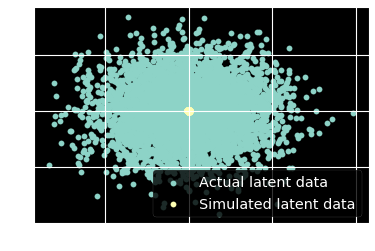

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [-1.64313008e-18 -2.55351296e-19]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[1.44798364e-04 5.01001604e-21]
 [5.01001604e-21 1.08694784e-04]]

Angermueller: iterative


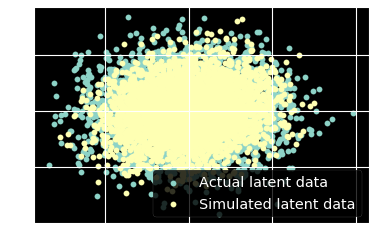

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [1.16529009e-16 5.93303184e-17]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[0.76117126 0.08910111]
 [0.08910111 0.70633608]]

Ymcdulls solution


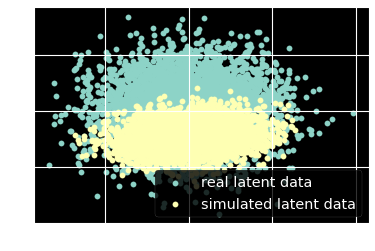

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [ 0.0209183  -0.87568873]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[0.63646754 0.05133599]
 [0.05133599 0.19345724]]

PyStan


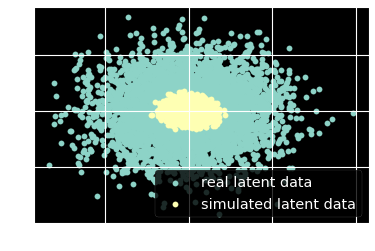

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [-8.38328262e-04 -6.31581139e-05]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[ 0.05489899 -0.00598763]
 [-0.00598763  0.04271856]]

TensorFlow


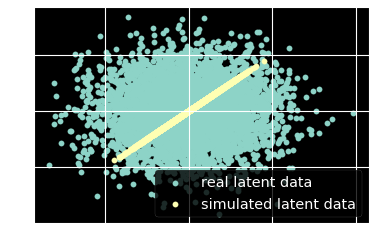

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [-0.000237 -0.000237]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[0.24260119 0.24260119]
 [0.24260119 0.24260119]]

PyPPCA


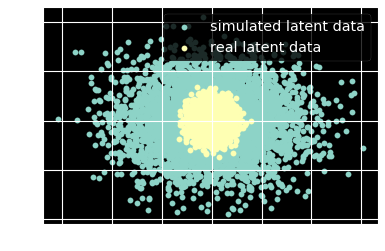

Mean of actual latent data:  [-0.0170718   0.00673077]
Mean of simulated latent data:  [-6.74393874e-16 -4.09894341e-17]
Covariance of actual latent data:
 [[0.9965434  0.01880457]
 [0.01880457 0.9715071 ]]
Covariance of simulated latent data:
 [[ 1.78599986e+01 -4.83265713e-17]
 [-4.83265713e-17  8.78340068e+00]]

Best simulated mean in terms of sum of squares:  PyStans solution
Best simulated covariance in terms of sum of squares:  Angermuellers iterative solution


In [67]:
real_latent_mean = np.mean(z, axis=1)
real_latent_cov = np.cov(z)

print('Angermueller: closed form')
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller[0,:],z_angermueller[1,:], label='Simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_angermueller, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_angermueller))
print()

print('Angermueller: iterative')
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller_em[0,:],z_angermueller_em[1,:], label='Simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_angermueller_em, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_angermueller_em))
print()

print('Ymcdulls solution')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(ymcdull_x[:, 0], ymcdull_x[:, 1], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(ymcdull_x.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(ymcdull_x.T))
print()

print('PyStan')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(z_sim_pystan[:,0], z_sim_pystan[:,1], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_sim_pystan.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_sim_pystan.T))
print()

print('TensorFlow')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(z_tf[0,:], z_tf[1,:], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_tf.numpy(), axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_tf.numpy()))
print()

print('PyPPCA')
plt.scatter(X_pyppca[:,0], X_pyppca[:,1], label='simulated latent data')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(X_pyppca.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(X_pyppca.T))
print()

min_mu = 10000
min_cov = 10000
solutions = ['Angermuellers closed solution', 'Angermuellers iterative solution', 'Ymcdulls solution', 'PyStans solution', 'TensorFlows solution', 'PyPPCAs solution']
solutions_var = [z_angermueller, z_angermueller_em,ymcdull_x.T, z_sim_pystan.T, z_tf.numpy(), X_pyppca.T]
for i in range(len(solutions)):
    if sum((np.mean(solutions_var[i], axis=1)-real_latent_mean)**2)<min_mu:
        min_mu = sum((np.mean(solutions_var[i], axis=1)-real_latent_mean)**2)
        best_solution_mu = solutions[i]
    if sum(sum((np.cov(solutions_var[i])-real_latent_cov)**2))<min_cov:
        min_cov = sum(sum((np.cov(solutions_var[i])-real_latent_cov)**2))
        best_solution_cov = solutions[i]
print('Best simulated mean in terms of sum of squares: ', best_solution_mu)
print('Best simulated covariance in terms of sum of squares: ', best_solution_cov)

## Visual representation of simulated observed data

my ppca: closed form


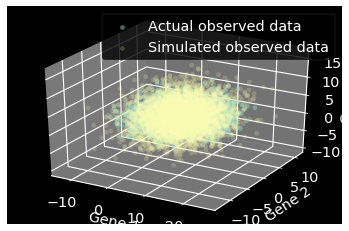

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [ 7.14584778 -0.99905629  2.44236786]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[22.37726251  4.13391746  1.09763283]
 [ 4.13391746 12.03760731 -1.62921289]
 [ 1.09763283 -1.62921289 13.91589314]]

Angermueller: closed form


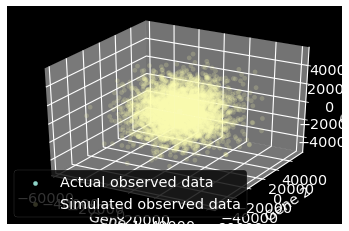

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [426.70302609   8.74434285 158.12034855]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[ 2.38964234e+08  5.34057878e+06  1.66330543e+06]
 [ 5.34057878e+06  2.43696512e+08 -2.17522037e+06]
 [ 1.66330543e+06 -2.17522037e+06  2.41942520e+08]]

my ppca: iterative


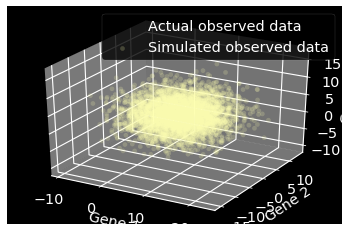

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [ 7.13127906 -1.03704026  2.46819184]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[23.05684828  4.00296398  2.03840927]
 [ 4.00296398 12.30548627 -1.81620562]
 [ 2.03840927 -1.81620562 14.02289474]]

Angermueller: iterative


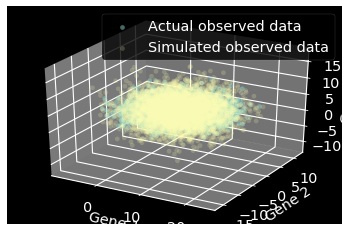

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [ 7.11646659 -0.97086846  2.52692669]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[23.02282644  4.01510663  1.24068589]
 [ 4.01510663 12.52204258 -1.73373857]
 [ 1.24068589 -1.73373857 13.82904255]]

PyStan


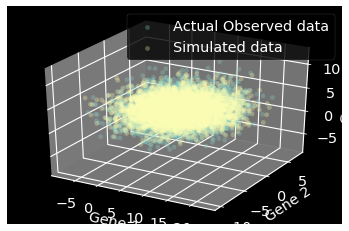

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [ 7.17707708 -0.99149677  2.46998075]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[16.9106613   4.90875147  2.16219295]
 [ 4.90875147  4.64256281 -3.03828398]
 [ 2.16219295 -3.03828398  8.10273195]]

TensorFlow


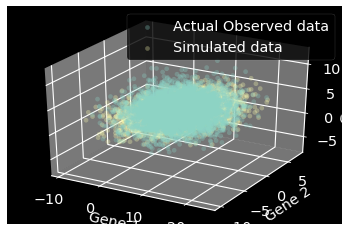

Mean of actual data:  [ 7.17561902 -0.97248221  2.46937992]
Mean of simulated data:  [ 7.21287   -0.9983883  2.4780297]
Covariance of actual data:
 [[16.35284436  4.12867244  1.63763498]
 [ 4.12867244  5.74564639 -1.88626959]
 [ 1.63763498 -1.88626959  7.67719579]]
Covariance of simulated data:
 [[18.79235718  5.12167514  1.61017823]
 [ 5.12167514  4.77285423  0.65213119]
 [ 1.61017823  0.65213119  3.24705432]]

Best simulated mean in terms of sum of squares:  PyStans solution
Best simulated covariance in terms of sum of squares:  PyStans solution


In [68]:
real_mean = np.mean(x, axis=1)
real_cov = np.cov(x)

print('my ppca: closed form')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.5, label='Actual observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_closed, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_closed))
print()

print('Angermueller: closed form')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data')
ax.scatter(x_angermueller[0,:],x_angermueller[1,:],x_angermueller[2,:], label='Simulated observed data', alpha=0.2)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_angermueller, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_angermueller))
print()

print('my ppca: iterative')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0., label='Actual observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_em, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_em))
print()


print('Angermueller: iterative')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data', alpha=0.5)
ax.scatter(x_angermueller_em[0,:],x_angermueller_em[1,:],x_angermueller_em[2,:], label='Simulated observed data', alpha=0.2)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_angermueller_em, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_angermueller_em))
print()


print('PyStan')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual Observed data', alpha=0.3)
ax.scatter(x_sim_pystan[:,0],x_sim_pystan[:,1],x_sim_pystan[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_pystan.T, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_pystan.T))
print()


print('TensorFlow')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], label='Actual Observed data', alpha=0.3)
ax.scatter(x_generated_mu[0,:],x_generated_mu[1,:],x_generated_mu[2,:], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_generated_mu, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_generated_mu))
print()

min_mu = 10000
min_cov = 10000
solutions = ['My closed solution', 'Angermuellers closed solution', 'my iterative solution', 'Angermuellers iterative solution', 'PyStans solution', 'TensorFlows solution']
solutions_var = [x_sim_closed,x_angermueller,x_sim_em, x_angermueller_em, x_sim_pystan.T, x_generated_mu]
for i in range(len(solutions)):
    if sum((np.mean(solutions_var[i], axis=1)-real_mean)**2)<min_mu:
        min_mu = sum((np.mean(solutions_var[i], axis=1)-real_mean)**2)
        best_solution_mu = solutions[i]
    if sum(sum((np.cov(solutions_var[i])-real_cov)**2))<min_cov:
        min_cov = sum(sum((np.cov(solutions_var[i])-real_cov)**2))
        best_solution_cov = solutions[i]
print('Best simulated mean in terms of sum of squares: ', best_solution_mu)
print('Best simulated covariance in terms of sum of squares: ', best_solution_cov)
